<a href="https://colab.research.google.com/github/Pranav-Tanwar/OJ_Project/blob/main/OC_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%%writefile sobel.cu
#include <iostream>
#include <fstream>
#include <vector>
#include <cmath>
#include <cstdlib>
#include <cuda_runtime.h>

// Error checking macro
#define cudaCheckError(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true) {
   if (code != cudaSuccess) {
      fprintf(stderr,"CUDA Error: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__global__ void sobelKernel(unsigned char* input, unsigned char* output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x > 0 && x < width - 1 && y > 0 && y < height - 1) {
        // Sobel kernels
        int Gx[3][3] = { {-1, 0, 1}, {-2, 0, 2}, {-1, 0, 1} };
        int Gy[3][3] = { {-1, -2, -1}, {0, 0, 0}, {1, 2, 1} };

        int sumX = 0;
        int sumY = 0;

        // Apply convolution
        for (int i = -1; i <= 1; i++) {
            for (int j = -1; j <= 1; j++) {
                int pixelVal = input[(y + i) * width + (x + j)];
                sumX += pixelVal * Gx[i + 1][j + 1];
                sumY += pixelVal * Gy[i + 1][j + 1];
            }
        }

        // Calculate magnitude
        int magnitude = (int)sqrtf((float)(sumX * sumX + sumY * sumY));
        if (magnitude > 255) magnitude = 255;
        output[y * width + x] = (unsigned char)magnitude;
    }
}

int main(int argc, char** argv) {
    if (argc != 5) {
        std::cerr << "Usage: ./sobel_filter <width> <height> <in.raw> <out.raw>" << std::endl;
        return 1;
    }

    int width = std::atoi(argv[1]);
    int height = std::atoi(argv[2]);
    size_t imgSize = width * height;

    // Allocate Host Memory
    std::vector<unsigned char> h_input(imgSize);
    std::vector<unsigned char> h_output(imgSize);

    // Read Input
    std::ifstream file(argv[3], std::ios::binary);
    if (!file) { std::cerr << "Error opening file" << std::endl; return 1; }
    file.read(reinterpret_cast<char*>(h_input.data()), imgSize);
    file.close();

    // Allocate Device Memory
    unsigned char *d_input, *d_output;
    cudaCheckError(cudaMalloc(&d_input, imgSize));
    cudaCheckError(cudaMalloc(&d_output, imgSize));

    // Copy to Device
    cudaCheckError(cudaMemcpy(d_input, h_input.data(), imgSize, cudaMemcpyHostToDevice));

    // Launch Kernel
    dim3 blockSize(16, 16);
    dim3 gridSize((width + 15) / 16, (height + 15) / 16);
    sobelKernel<<<gridSize, blockSize>>>(d_input, d_output, width, height);
    cudaCheckError(cudaPeekAtLastError());
    cudaCheckError(cudaDeviceSynchronize());

    // Copy back to Host
    cudaCheckError(cudaMemcpy(h_output.data(), d_output, imgSize, cudaMemcpyDeviceToHost));

    // Write Output
    std::ofstream outfile(argv[4], std::ios::binary);
    outfile.write(reinterpret_cast<const char*>(h_output.data()), imgSize);
    outfile.close();

    cudaFree(d_input);
    cudaFree(d_output);
    return 0;
}

Overwriting sobel.cu


In [21]:
import os

# 1. Check which GPU Colab assigned to you
gpu_info = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()
print(f"Detected GPU: {gpu_info}")

if not gpu_info:
    raise Exception("NO GPU DETECTED. Please go to Runtime > Change runtime type > Select T4 GPU.")

# 2. Select the correct Architecture Flag
arch_flag = ""
if "T4" in gpu_info:
    arch_flag = "-arch=sm_75"
elif "P100" in gpu_info:
    arch_flag = "-arch=sm_60"
elif "V100" in gpu_info:
    arch_flag = "-arch=sm_70"
elif "A100" in gpu_info:
    arch_flag = "-arch=sm_80"
else:
    print("Unknown GPU type. Attempting generic compilation...")

# 3. Compile
print(f"Compiling for {arch_flag}...")
compile_cmd = f"nvcc {arch_flag} -o sobel_filter sobel.cu"
exit_code = os.system(compile_cmd)

if exit_code == 0:
    print("Compilation Successful! Executable 'sobel_filter' created.")
else:
    print("Compilation Failed. Check the output above.")

Detected GPU: Tesla T4
Compiling for -arch=sm_75...
Compilation Successful! Executable 'sobel_filter' created.


In [22]:
import numpy as np
from PIL import Image, ImageDraw

# Create a test image (Red circle on Blue background)
width, height = 512, 512
img = Image.new('RGB', (width, height), color = 'blue')
d = ImageDraw.Draw(img)
d.ellipse((128, 128, 384, 384), fill=(255, 0, 0))

# Convert to Raw Grayscale (L)
gray_img = img.convert('L')
with open('input.raw', 'wb') as f:
    f.write(gray_img.tobytes())

print(f"Input image created ({width}x{height}) and saved as 'input.raw'.")

Input image created (512x512) and saved as 'input.raw'.


Running Sobel Edge Detection on GPU...
GPU Execution Successful.


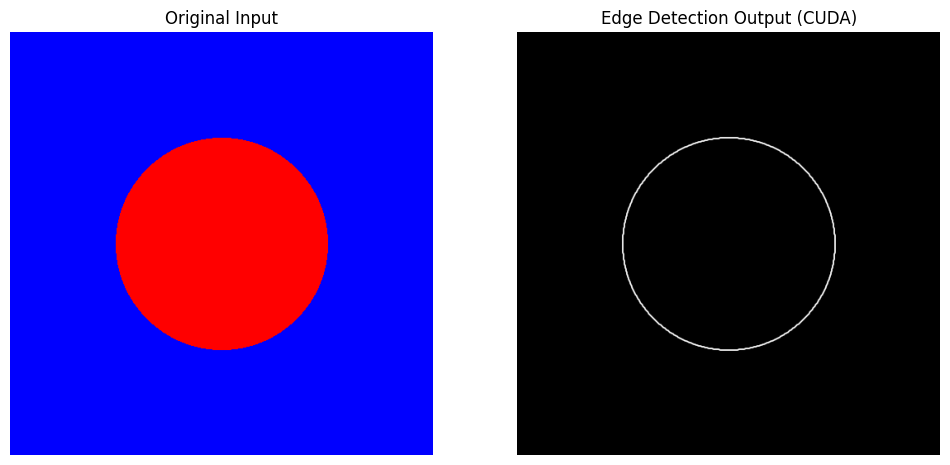

Demo Complete!


In [23]:
import matplotlib.pyplot as plt
import os

# 1. Run the C++ executable
print("Running Sobel Edge Detection on GPU...")
run_cmd = f"./sobel_filter {width} {height} input.raw output.raw"
exit_code = os.system(run_cmd)

if exit_code == 0:
    print("GPU Execution Successful.")

    # 2. Load Raw Output
    try:
        with open('output.raw', 'rb') as f:
            raw_data = f.read()

        # Convert raw bytes back to image object
        output_img = Image.frombytes('L', (width, height), raw_data)

        # 3. Plot Side-by-Side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Show Original (Python object)
        axes[0].imshow(img)
        axes[0].set_title("Original Input")
        axes[0].axis('off')

        # Show Result (Processed by CUDA)
        axes[1].imshow(output_img, cmap='gray')
        axes[1].set_title("Edge Detection Output (CUDA)")
        axes[1].axis('off')

        plt.show()

    except FileNotFoundError:
        print("Error: Output file was not found.")
else:
    print(f"Execution Failed with return code {exit_code}.")